In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from datetime import datetime
%matplotlib inline

In [2]:
main_start = datetime.now()
raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

raw_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
# Let's take a look at the type of data in each column
# Drop the CustomerID since it's a unique key that means nothing to us.
data = raw_data.drop(['customerID'], axis=1)
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
#It appears that Total Charges is coming in as a string, so let's make it numeric
data['TotalCharges'] = data['TotalCharges'].convert_objects(convert_numeric=True)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [5]:
# Let's check the data for nulls
null_count = data.isnull().sum()
null_count[null_count>0]

TotalCharges    11
dtype: int64

In [6]:
# There appears to be 11 rows that are missing Total Charges. Since the number is insignificant, let's drop the rows.
data = data.dropna(axis=0)

In [7]:
#For the columns that only have 2 values yes or no, let's convert them to 0s and 1s
#Hold off on converting Churn to 0s and 1s for graphs below
Yes_No_Columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for feature in Yes_No_Columns:
    data[feature] = np.where(data[feature].values == 'Yes', 1, 0)

#Now let's convert the Males/Females in 0 (Males) and 1 (Females)
data['gender'] = np.where(data.gender.values == 'Female', 1, 0)

#Let's see what we've created
data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,No
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,No
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,Yes
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,No
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,Yes
5,1,0,0,0,8,1,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,99.65,820.50,Yes
6,0,0,0,1,22,1,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,1,Credit card (automatic),89.10,1949.40,No
7,1,0,0,0,10,0,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,0,Mailed check,29.75,301.90,No
8,1,0,1,0,28,1,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,1,Electronic check,104.80,3046.05,Yes
9,0,0,0,1,62,1,No,DSL,Yes,Yes,No,No,No,No,One year,0,Bank transfer (automatic),56.15,3487.95,No


In [8]:
#Now convert Churn to 0s and 1s.
data['Churn'] = np.where(data['Churn'].values == 'Yes', 1, 0)
#Let's get dummies for the columns with multiple answers
multiple_answers = ['MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']

data = pd.get_dummies(data, columns=multiple_answers)

In [9]:
data['tenure_norm'] = (data['tenure'] - min(data['tenure']))/ (max(data['tenure']) - min(data['tenure']))
data['MonthlyCharges_norm'] = (data['MonthlyCharges'] - min(data['MonthlyCharges']))/ (max(data['MonthlyCharges']) - min(data['MonthlyCharges']))
data['TotalCharges_norm'] = (data['TotalCharges'] - min(data['TotalCharges']))/ (max(data['TotalCharges']) - min(data['TotalCharges']))
model_data = data.drop(['TotalCharges', 'MonthlyCharges', 'tenure'], axis=1)

In [10]:
# Create a separate yes and no variable
yes_churn = model_data[model_data.Churn == 1]
no_churn = model_data[model_data.Churn == 0]

# Use resample to get an equal number of yes and nos in our data
model_data = resample(no_churn, n_samples=1869)
model_data = model_data.append(yes_churn)

# Now we can create our X and Y variables
X = model_data.drop(['Churn'], 1)
y = model_data['Churn']

#Make a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


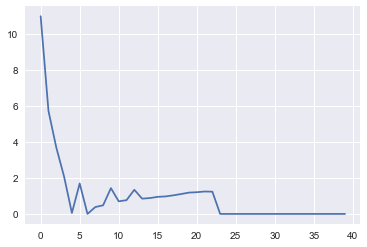

In [11]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1.
X = StandardScaler().fit_transform(X_train)

# Transpose X to use with NumPy
Xt = X.T
Cx = np.cov(Xt)
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
# Plot the eigenvalues
plt.plot(eig_val_cov)
plt.show()

In [12]:
#Set up our first X using PCA
pca = PCA(n_components=4)
X_std_pca = pca.fit_transform(X_train)
PCA_X = pd.DataFrame(X_std_pca)

#Now for the Test
pca = PCA(n_components=4)
X_std_pca = pca.fit_transform(X_test)
PCA_Xtest = pd.DataFrame(X_std_pca)

In [13]:
start = datetime.now()
#Use Lasso/RFE with Cross Validation to get the best features for our second X
lr = LogisticRegression(C=1, penalty='l1')

#Set up our X,y
X = X_train
y = y_train

#Set up our Recursive Feature Elimination
rfe = RFECV(lr,cv=5) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))
print('It took the following time to complete this task:', datetime.now() - start)

                                   Features  Ranking  Support
39                        TotalCharges_norm        1     True
29                      StreamingMovies_Yes        1     True
30                  Contract_Month-to-month        1     True
15                          OnlineBackup_No        1     True
32                        Contract_Two year        1     True
33  PaymentMethod_Bank transfer (automatic)        1     True
12                        OnlineSecurity_No        1     True
11                       InternetService_No        1     True
9                       InternetService_DSL        1     True
37                              tenure_norm        1     True
6                          MultipleLines_No        1     True
5                          PaperlessBilling        1     True
3                                Dependents        1     True
2                                   Partner        1     True
35           PaymentMethod_Electronic check        1     True
21      

In [14]:
# Save the features to a list to use in our modeling
true_values = result_RFE[result_RFE.Support == True]
feature_list = []
for g in true_values['Features']:
    feature_list.append(g)

# Create our X for the training and test sets using the recommended features.
RFE_X = X_train[feature_list]
RFE_Xtest = X_test[feature_list]

In [15]:
# Let's use Random Forest to select features.
start = datetime.now()
X = X_train
y = y_train
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
feature_df = X.columns.get_values()
feat_labels = feature_df.tolist()

# Train the classifier
clf.fit(X, y)
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
for feature in zip(X, clf.feature_importances_):
    print(feature)

print('It took the following time to complete this task:', datetime.now() - start)

('gender', 0.024872962036801411)
('SeniorCitizen', 0.017866927333995059)
('Partner', 0.021250721413152658)
('Dependents', 0.017686773721578366)
('PhoneService', 0.0039542311888356215)
('PaperlessBilling', 0.02292495794830339)
('MultipleLines_No', 0.012214208679295218)
('MultipleLines_No phone service', 0.0040210123700195246)
('MultipleLines_Yes', 0.011940033851876614)
('InternetService_DSL', 0.01198178367355365)
('InternetService_Fiber optic', 0.029662981039220285)
('InternetService_No', 0.0050676532838968046)
('OnlineSecurity_No', 0.029364537004145114)
('OnlineSecurity_No internet service', 0.0049984504538319987)
('OnlineSecurity_Yes', 0.010857871225979263)
('OnlineBackup_No', 0.015612379523030198)
('OnlineBackup_No internet service', 0.005779242956972859)
('OnlineBackup_Yes', 0.011520065318502594)
('DeviceProtection_No', 0.014233363029183493)
('DeviceProtection_No internet service', 0.0046877045367901974)
('DeviceProtection_Yes', 0.011109767181623046)
('TechSupport_No', 0.03959505357

In [16]:
start = datetime.now()

# Retrieve the most important features by using SelectFromModel with a given threshold 
sfm = SelectFromModel(clf, threshold=0.03)
rfcfeature_list =[]
# Train the selector
sfm.fit(X, y)
for feature_list_index in sfm.get_support(indices=True):
    rfcfeature_list.append(feat_labels[feature_list_index])
    print(feat_labels[feature_list_index])

RFC_X = X_train[rfcfeature_list]
RFC_Xtest = X_test[rfcfeature_list]
     
print('Number of features in this list: {}'.format(len(rfcfeature_list)))
print('It took the following time to complete this task:', datetime.now() - start)

TechSupport_No
Contract_Month-to-month
Contract_Two year
tenure_norm
MonthlyCharges_norm
TotalCharges_norm
Number of features in this list: 6
It took the following time to complete this task: 0:00:02.808078


In [17]:
#Make a list to store our results for a comparison at the end
results = pd.DataFrame(index=range(9))
results['Model'] = ['Random Forest',
                    'Random Forest',
                    'Random Forest',
                    'Gradient Booster',
                    'Gradient Booster',
                    'Gradient Booster',
                    'Neural Network',
                    'Neural Network',
                    'Neural Network'
                    ]
results['Feature Selection'] = ['PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest',
                               'PCA', 'RFECV', 'Random Forest']


Train_Score = []
Test_Score = []
Cross_Validation = []
fold1 = []
fold2 = []
fold3 = []
fold4 = []
fold5 = []

In [18]:
#Create a testing function that will fit the test with PCA and our selected features from both RFECV and Random Forest
def testing_func(test):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in
    models = [[PCA_X, y], [PCA_Xtest, y_test], [RFE_X, y],[RFE_Xtest, y_test], [RFC_X, y], [RFC_Xtest, y_test]]
    for x in models:
        test.fit(x[0], x[1])
        scores.append(test.score(x[0], x[1]))
    
    #Let's store the results from our local list into the main list
    p=1
    for s in scores:
        p+=1
        if p % 2 == 0:
            Train_Score.append(s)
        else:
            Test_Score.append(s)

    # Create a local dataframe to display our results cleanly
    local_results_df=pd.DataFrame(scores, columns=['Accuracy'], index=['PCA Training', 'PCA Test', 'RFECV Training',
                                                                       'RFECV Test', 'Random Forest Training' , 
                                                                       'Random Forest Test'])
    print(local_results_df)
    
    #Create a list and put it through a For loop to do the Cross Validation
    exes = [[PCA_X, 'PCA'], [RFE_X, 'RFECV'], [RFC_X, 'Random Forest']]
    for x in exes:
        Cross_Validation0 = cross_val_score(test, x[0], y, cv=5)
        Cross_Validation.append(Cross_Validation0)
        
        #Divide up the results into 5 different folds for display
        fold1.append(Cross_Validation0[0])
        fold2.append(Cross_Validation0[1])
        fold3.append(Cross_Validation0[2])
        fold4.append(Cross_Validation0[3])
        fold5.append(Cross_Validation0[4])
        print('\nCross Validation Score with 5 folds with {}:\n{}'.format(x[1], Cross_Validation0))

In [19]:
#Run the same optimization tool for Random Forest.

start = datetime.now()
rfc = RandomForestClassifier()
parameters = {'n_estimators':[10, 100, 1000, 5000], 'max_depth':[2,4,6,8,10]}
grid = GridSearchCV(rfc, parameters).fit(RFE_X, y)
predicted = grid.predict(RFE_Xtest)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_
print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'max_depth': 6, 'n_estimators': 5000} with a score of %0.7791533546325878
It took the following time to complete this task: 0:03:28.378272


In [20]:
# Run Random Forest using the parameters selected above.
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=parameters['n_estimators'],
                             max_depth=parameters['max_depth'], 
                             min_samples_leaf=1, 
                             max_leaf_nodes=4)

testing_func(rfc)

print('It took the following time to complete this task:', datetime.now() - start)

                        Accuracy
PCA Training            0.760383
PCA Test                0.747974
RFECV Training          0.769569
RFECV Test              0.743922
Random Forest Training  0.770767
Random Forest Test      0.743112

Cross Validation Score with 5 folds with PCA:
[ 0.74900398  0.77091633  0.756       0.732       0.764     ]

Cross Validation Score with 5 folds with RFECV:
[ 0.76494024  0.80876494  0.754       0.756       0.758     ]

Cross Validation Score with 5 folds with Random Forest:
[ 0.77290837  0.79880478  0.738       0.77        0.752     ]
It took the following time to complete this task: 0:03:19.711819


In [21]:
# Run the same optimization tool for gradient boosting
start = datetime.now()
clf = GradientBoostingClassifier()
parameters = {'n_estimators':[1, 10, 20, 50], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0],
              'max_depth':[2,4,6,8,10]}
grid = GridSearchCV(clf, parameters).fit(RFE_X, y)
predicted = grid.predict(RFE_Xtest)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_
print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50} with a score of %0.777555910543131
It took the following time to complete this task: 0:00:35.942033


In [22]:
# Run Gradient Boosting using the above.
start = datetime.now()
clf = GradientBoostingClassifier(loss='exponential', learning_rate=parameters['learning_rate'], 
                                 n_estimators=parameters['n_estimators'], subsample=0.75, 
                                 max_depth=parameters['max_depth'])

testing_func(clf)

print('It took the following time to complete this task:', datetime.now() - start)

                        Accuracy
PCA Training            0.774760
PCA Test                0.752026
RFECV Training          0.787540
RFECV Test              0.764992
Random Forest Training  0.781550
Random Forest Test      0.780389

Cross Validation Score with 5 folds with PCA:
[ 0.75498008  0.7689243   0.768       0.738       0.752     ]

Cross Validation Score with 5 folds with RFECV:
[ 0.78486056  0.80278884  0.762       0.766       0.77      ]

Cross Validation Score with 5 folds with Random Forest:
[ 0.78087649  0.80278884  0.752       0.76        0.756     ]
It took the following time to complete this task: 0:00:01.337520


In [23]:
# SKlearn has a tool that will optimize SVC
start = datetime.now()
mlp = MLPClassifier()
# Set the hyperparameters
parameters = {'hidden_layer_sizes':[(400, 50, 25), (500, 100), (500, 100, 4), (1000, 4)], 'alpha': 
              [0.01,0.03,0.05,0.10], 'learning_rate': ['constant', 'adaptive'], 'activation': ['relu', 'logistic']}
# Run it through the tool.
grid = GridSearchCV(mlp, parameters).fit(PCA_X, y)
predicted = grid.predict(PCA_Xtest)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_

print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (1000, 4), 'learning_rate': 'constant'} with a score of %0.7691693290734825
It took the following time to complete this task: 0:04:22.241468


In [24]:
start = datetime.now()
mlp = MLPClassifier(hidden_layer_sizes=parameters['hidden_layer_sizes'],
                   alpha=parameters['alpha'],
                   learning_rate=parameters['learning_rate'],
                   activation=parameters['activation'])
testing_func(mlp)

print('It took the following time to complete this task:', datetime.now() - start)

                        Accuracy
PCA Training            0.770767
PCA Test                0.739060
RFECV Training          0.782748
RFECV Test              0.820908
Random Forest Training  0.770367
Random Forest Test      0.752026

Cross Validation Score with 5 folds with PCA:
[ 0.75896414  0.7749004   0.76        0.754       0.774     ]

Cross Validation Score with 5 folds with RFECV:
[ 0.77689243  0.80876494  0.748       0.764       0.762     ]

Cross Validation Score with 5 folds with Random Forest:
[ 0.7749004   0.81673307  0.74        0.768       0.762     ]
It took the following time to complete this task: 0:00:28.174714


In [25]:
# Display our results cleanly
results2 = pd.DataFrame({'Train Score': Train_Score, 'Test Score': Test_Score, 'CV Fold 1': fold1,
                            'CV Fold 2': fold2, 'CV Fold 3': fold3, 'CV Fold 4': fold4, 'CV Fold 5': fold5})
results2['CV Mean'] = (results2['CV Fold 1'] + results2['CV Fold 2'] + results2['CV Fold 3'] + 
                       results2['CV Fold 4'] + results2['CV Fold 5']) / 5
results = pd.concat([results, results2], axis=1)

results.head(9)

,Model,Feature Selection,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5,Test Score,Train Score,CV Mean
0,Random Forest,PCA,0.749004,0.770916,0.756,0.732,0.764,0.747974,0.760383,0.754384
1,Random Forest,RFECV,0.764940,0.808765,0.754,0.756,0.758,0.743922,0.769569,0.768341
2,Random Forest,Random Forest,0.772908,0.798805,0.738,0.770,0.752,0.743112,0.770767,0.766343
3,Gradient Booster,PCA,0.754980,0.768924,0.768,0.738,0.752,0.752026,0.774760,0.756381
4,Gradient Booster,RFECV,0.784861,0.802789,0.762,0.766,0.770,0.764992,0.787540,0.777130
5,Gradient Booster,Random Forest,0.780876,0.802789,0.752,0.760,0.756,0.780389,0.781550,0.770333
6,Neural Network,PCA,0.758964,0.774900,0.760,0.754,0.774,0.739060,0.770767,0.764373
7,Neural Network,RFECV,0.776892,0.808765,0.748,0.764,0.762,0.820908,0.782748,0.771931
8,Neural Network,Random Forest,0.774900,0.816733,0.740,0.768,0.762,0.752026,0.770367,0.772327


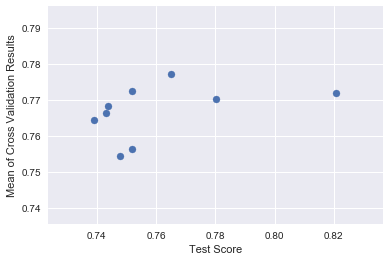

In [26]:
# Plot them. Our goal is the get as many points in the upper right hand corner as possible.
x = results['Test Score']
y = results['CV Mean']
plt.xlabel('Test Score')
plt.ylabel('Mean of Cross Validation Results')
plt.scatter(x, y)
plt.show()

Of the three models (Random Forest, Gradient Boosting, and MLP), Gradient Boosting performed the best overall in terms of accuracy and processing.

In [27]:
print('It took the following time to complete this notebook:', datetime.now() - main_start)

It took the following time to complete this notebook: 0:12:24.825315
